In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import os
from itertools import chain
import torch
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

from deepthermal.FFNN_model import fit_FFNN, FFNN, init_xavier
from deepthermal.validation import create_subdictionary_iterator, k_fold_cv_grid, add_dictionary_iterators
from deepthermal.plotting import plot_result, plot_model_1d

from deep_reparametrization.reparametrization import (
    get_elastic_metric_loss,
    compute_loss_reparam,
    get_elastic_error_func,
)
from deep_reparametrization.ResNET import ResNET, init_zero
import experiments.curves as c1

# make reproducible
torch.manual_seed(0)

In [70]:
########
DIR = "../figures/curve_1/"
SET_NAME = "eks_5"
PATH_FIGURES = os.path.join(DIR, SET_NAME)
if not os.path.exists(PATH_FIGURES):
    os.makedirs(PATH_FIGURES)
########


FOLDS = 1
N = 128  # training points internal
# lr_scheduler  = lambda optim:  torch.optim.lr_scheduler.ReduceLROnPlateau(optim , mode='min', factor=0.8, patience=10, verbose=True)
loss_func = get_elastic_metric_loss(r=c1.r, constrain_cost=1e3, verbose=False)
no_penalty_loss_func = get_elastic_metric_loss(r=c1.r, constrain_cost=0, verbose=False)

MODEL_PARAMS = {
    "input_dimension": [1],
    "output_dimension": [1],
    "activation": ["tanh"],
    "n_hidden_layers": [2],
    "neurons": [2, 4, 8, 16, 32, 64, 128, 256]
}
MODEL_PARAMS_2 = {
    "input_dimension": [1],
    "output_dimension": [1],
    "activation": ["tanh"],
    "n_hidden_layers": [1, 2, 4, 8, 16, 32],
    "neurons": [8],
}
# extend the previous dict with the zip of this
MODEL_PARAMS_EXPERIMENT = {
    "model": [FFNN, ResNET],
}
TRAINING_PARAMS = {
    "batch_size": [N],
    "regularization_param": [0],
    "compute_loss": [compute_loss_reparam],
    "loss_func": [loss_func],
}
# extend the previous dict with the zip of this
TRAINING_PARAMS_EXPERIMENT = {
    "optimizer": ["strong_wolfe"],
    "num_epochs": [10],
    "learning_rate": [1],
}

In [71]:
# create iterators
model_params_iter_1 = create_subdictionary_iterator(MODEL_PARAMS)
model_params_iter_2 = create_subdictionary_iterator(MODEL_PARAMS_2)
model_params_iter = chain.from_iterable((model_params_iter_1, model_params_iter_2))

model_exp_iter = create_subdictionary_iterator(MODEL_PARAMS_EXPERIMENT, product=False)
exp_model_params_iter = add_dictionary_iterators(model_exp_iter, model_params_iter)

training_params_iter = create_subdictionary_iterator(TRAINING_PARAMS)
training_exp_iter = create_subdictionary_iterator(TRAINING_PARAMS_EXPERIMENT, product=False)
exp_training_params_iter = add_dictionary_iterators(training_exp_iter, training_params_iter)

In [72]:
# Load data
x_train = torch.linspace(0, 1, N, requires_grad=True).unsqueeze(1)
q_train = c1.q(x_train.detach())

data = TensorDataset(x_train, q_train)


Do the actual training

In [73]:
cv_results = k_fold_cv_grid(
    model_params=exp_model_params_iter,
    fit=fit_FFNN,
    training_params=exp_training_params_iter,
    data=data,
    folds=FOLDS,
    verbose=True,
    trials=10
)


Running model (trial=0, mod=0, k=0):
Parameters: ({'input_dimension': 1, 'output_dimension': 1, 'activation': 'tanh', 'n_hidden_layers': 2, 'neurons': 2, 'model': <class 'deepthermal.FFNN_model.FFNN'>}, {'batch_size': 128, 'regularization_param': 0, 'compute_loss': <function compute_loss_reparam at 0x122dd5f70>, 'loss_func': <function get_elastic_metric_loss.<locals>.elastic_metric_loss at 0x124cf00d0>, 'optimizer': 'strong_wolfe', 'num_epochs': 10, 'learning_rate': 1})
################################  0  ################################
Training Loss:  0.93418568
Training Loss:  0.93418568
Training Loss:  0.93418568
Training Loss:  0.93388301
Training Loss:  0.93388301
Training Loss:  0.93388301
Training Loss:  0.93386149
Training Loss:  0.93384498
Training Loss:  0.93384498
Training Loss:  0.93384498
Final training Loss:  0.93384498

Running model (trial=0, mod=1, k=0):
Parameters: ({'input_dimension': 1, 'output_dimension': 1, 'activation': 'tanh', 'n_hidden_layers': 2, 'neurons':

In [90]:
# plotting

x_train_ = x_train.detach()
x_sorted, indices = torch.sort(x_train_, dim=0)
plot_kwargs = {
    "x_test": x_sorted,
    "x_train": x_sorted,
    "y_train": c1.ksi(x_sorted),
    "x_axis": "t",
    "y_axis": "$\\varphi(t)$",
    "compare_label": "Analytical solution"
}
plot_result(
    path_figures=PATH_FIGURES,
    **cv_results,
    plot_function=plot_model_1d,
    function_kwargs=plot_kwargs,
)

In [91]:


models = cv_results["models"]

parameters = np.vectorize(lambda model: sum(p.numel() for p in model.parameters()))(models).flatten()
model_type = np.vectorize(str)(models).flatten()
layers = np.vectorize(lambda model: model.n_hidden_layers)(models).flatten()
neurons = np.vectorize(lambda model: model.neurons)(models).flatten()
loss_array = np.vectorize(lambda model: no_penalty_loss_func(model, x_train, q_train).detach())(models).flatten()

# make data frame
d_results = pd.DataFrame(
    {"loss": loss_array, "neurons": neurons, "layers": layers, "parameters": parameters, "model": model_type})

d_results_layer = d_results[d_results.neurons == 8]
d_results_neurons = d_results[d_results.layers == 2]

/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


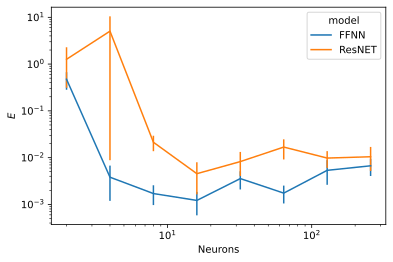

In [92]:
fig_neurons = sns.lineplot(data=d_results_neurons, y="loss", x="neurons", hue="model", ci=80, err_style="bars")
fig_neurons.set(xscale="log", yscale="log", xlabel="Neurons")
fig_neurons.set(ylabel="$E$")
plt.savefig(f"{PATH_FIGURES}/neurons_error.pdf")
plt.show()


In [93]:
print("faled, total:")
print(len(d_results_neurons[d_results_neurons.loss > 1]), len(d_results_neurons))

faled, total:
4 180


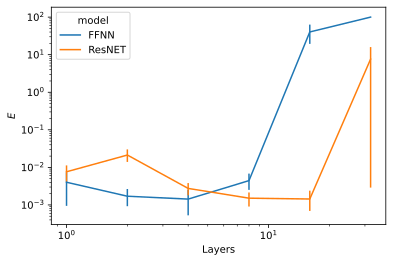

In [94]:
fig_layers = sns.lineplot(data=d_results_layer, y="loss", x="layers", hue="model", ci=80, err_style="bars")
fig_layers.set(yscale="log", xscale="log", xlabel="Layers", ylabel="Error")
fig_layers.set(ylabel="$E$")
plt.savefig(f"{PATH_FIGURES}/layer_error.pdf")
plt.show()


In [95]:
print("faled, total:")
print(len(d_results_layer[d_results_layer.loss
                          > 1]), len(d_results_layer))

faled, total:
16 140


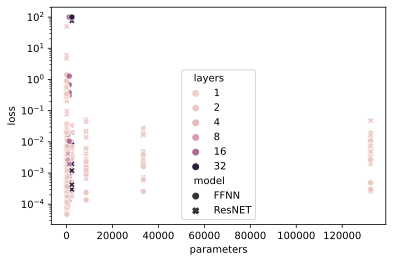

In [96]:
fig_scatter = sns.scatterplot(data=d_results, y="loss", x="parameters", hue="layers", style="model")
fig_neurons.set(ylabel="$E$")
fig_scatter.set(yscale="log")
plt.show()

In [97]:
print(len(d_results[d_results.loss < 2]), len(d_results))

261 280


In [98]:
d_results.to_csv(f"{PATH_FIGURES}/d_results.csv")